# 量化金融预测

In [72]:
# 导入模块
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import f1_score
import sys, os, warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [73]:
# 数据导入
train_file = os.listdir('input/train/')
test_file = os.listdir('input/test/')
train = pd.DataFrame()
test = pd.DataFrame()
# 读取训练数据
for file in train_file:
    tmp = pd.read_csv('input/train/'+file)
    tmp['file'] = file
    train = pd.concat([train, tmp], axis=0, ignore_index=True)
# 读取测试数据
for file in test_file:
    tmp = pd.read_csv('input/test/'+file)
    tmp['file'] = file
    test = pd.concat([test, tmp], axis=0, ignore_index=True)

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239880 entries, 0 to 239879
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          239880 non-null  int64  
 1   date          239880 non-null  int64  
 2   time          239880 non-null  object 
 3   sym           239880 non-null  int64  
 4   n_close       239880 non-null  float64
 5   amount_delta  239880 non-null  float64
 6   n_midprice    239880 non-null  float64
 7   n_bid1        239880 non-null  float64
 8   n_bsize1      239880 non-null  float64
 9   n_bid2        239880 non-null  float64
 10  n_bsize2      239880 non-null  float64
 11  n_bid3        239880 non-null  float64
 12  n_bsize3      239880 non-null  float64
 13  n_bid4        239880 non-null  float64
 14  n_bsize4      239880 non-null  float64
 15  n_bid5        239880 non-null  float64
 16  n_bsize5      239880 non-null  float64
 17  n_ask1        239880 non-null  float64
 18  n_as

In [75]:
train.head()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
0,0,0,09:40:03,1,-0.007605,2081.0,-0.009506,-0.011407,0.000222,-0.015209,...,0.003802,0.000162,0.007605,0.000262,1,0,0,0,1,snapshot_sym1_date0_am.csv
1,1,0,09:40:06,1,-0.011407,129268.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000264,1,0,0,0,1,snapshot_sym1_date0_am.csv
2,2,0,09:40:09,1,-0.007605,76098.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
3,3,0,09:40:12,1,-0.007605,2613280.0,-0.009506,-0.011407,0.000174,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
4,4,0,09:40:15,1,-0.011407,327615.0,-0.009506,-0.011407,0.000112,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv


In [76]:
train.tail()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
239875,1994,9,14:49:45,1,0.0,618749.0,0.001845,0.0,0.000202,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239876,1995,9,14:49:48,1,0.0,129328.0,0.001845,0.0,0.000201,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239877,1996,9,14:49:51,1,0.0,84124.0,0.001845,0.0,0.000205,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239878,1997,9,14:49:54,1,0.0,0.0,0.001845,0.0,0.000205,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239879,1998,9,14:49:57,1,0.0,9227.0,0.001845,0.0,0.000207,-0.00369,...,0.01476,0.00067,0.01845,0.000494,1,1,1,1,1,snapshot_sym1_date9_pm.csv


In [59]:
train.describe()

,uuid,date,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
count,239880.000000,239880.000000,239880.0,239880.000000,2.398800e+05,239880.000000,239880.000000,2.398800e+05,239880.000000,2.398800e+05,...,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000
mean,999.000000,29.783333,1.0,0.006398,8.518432e+05,0.006367,0.004891,3.757366e-04,0.001828,3.144186e-04,...,0.000309,0.012272,0.000307,0.014930,0.000294,1.001401,1.000913,0.998424,0.997457,0.996790
std,577.062725,17.671663,0.0,0.028634,7.481202e+06,0.028595,0.028756,9.289055e-04,0.028720,1.877919e-04,...,0.000241,0.021109,0.000252,0.020870,0.000231,0.320780,0.398801,0.488519,0.585648,0.640166
min,0.000000,0.000000,1.0,-0.081818,0.000000e+00,-0.082955,-0.084091,2.873695e-09,-0.086364,2.873695e-09,...,0.000000,-0.075000,0.000000,-0.072727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,499.000000,14.750000,1.0,-0.007752,3.559225e+04,-0.008861,-0.010127,7.660985e-05,-0.012658,1.661127e-04,...,0.000143,0.000000,0.000149,0.002597,0.000151,1.000000,1.000000,1.000000,1.000000,1.000000
50%,999.000000,29.500000,1.0,0.002457,2.013915e+05,0.001873,0.000000,1.668456e-04,-0.003731,2.845122e-04,...,0.000294,0.011450,0.000289,0.015038,0.000279,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1499.000000,45.250000,1.0,0.013908,7.295142e+05,0.013672,0.011719,3.246684e-04,0.009259,4.264966e-04,...,0.000427,0.022113,0.000411,0.024000,0.000392,1.000000,1.000000,1.000000,1.000000,1.000000
max,1998.000000,60.000000,1.0,0.100239,3.440177e+09,0.100239,0.100239,7.819406e-03,0.097852,1.138172e-03,...,0.004537,0.100239,0.004548,0.100239,0.004616,2.000000,2.000000,2.000000,2.000000,2.000000


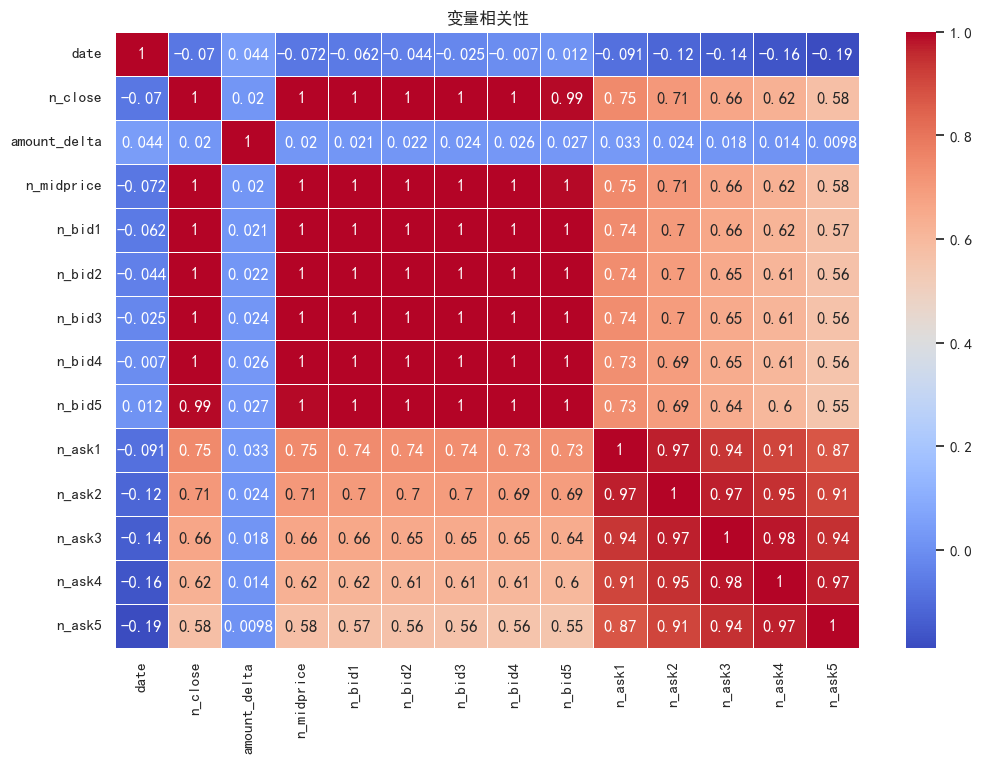

In [77]:
# 画相关图
cols_x = [f for f in test.columns if f not in 
          ['uuid','time','file','sym','label_5','label_10','label_20','label_40','label_60',
           'n_bsize1', 'n_bsize2', 'n_bsize3', 'n_bsize4', 'n_bsize5',
           'n_asize1', 'n_asize2', 'n_asize3', 'n_asize4', 'n_asize5']]
train_corr = train[cols_x]
correlation_matrix = train_corr.corr()
# 设置 seaborn 风格
sns.set(style="white")
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('变量相关性')
plt.show()


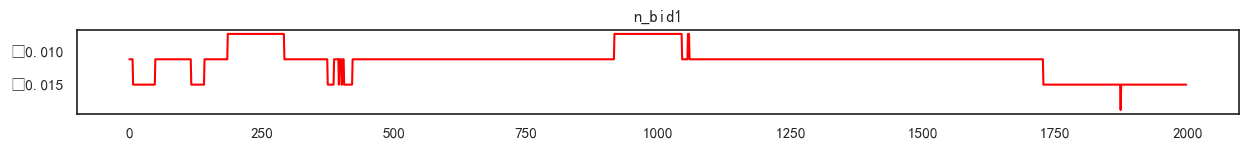

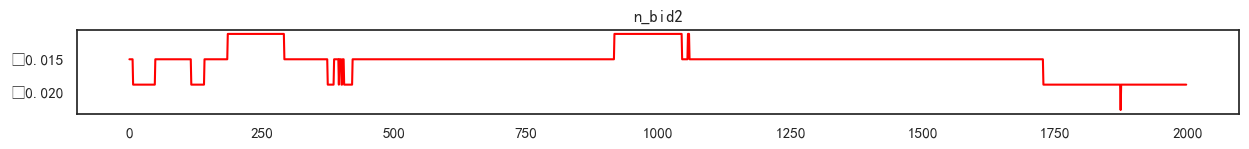

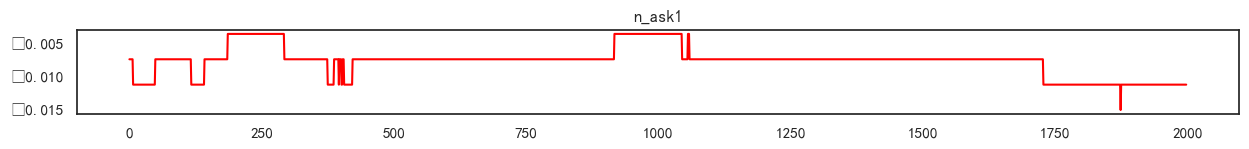

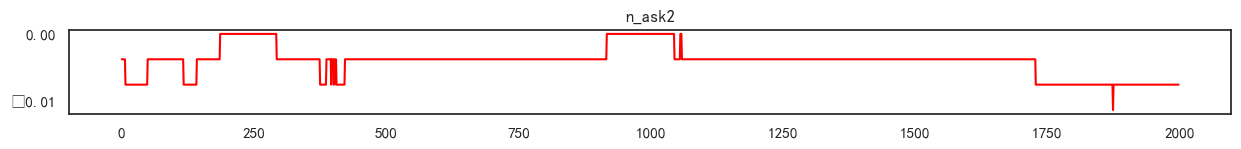

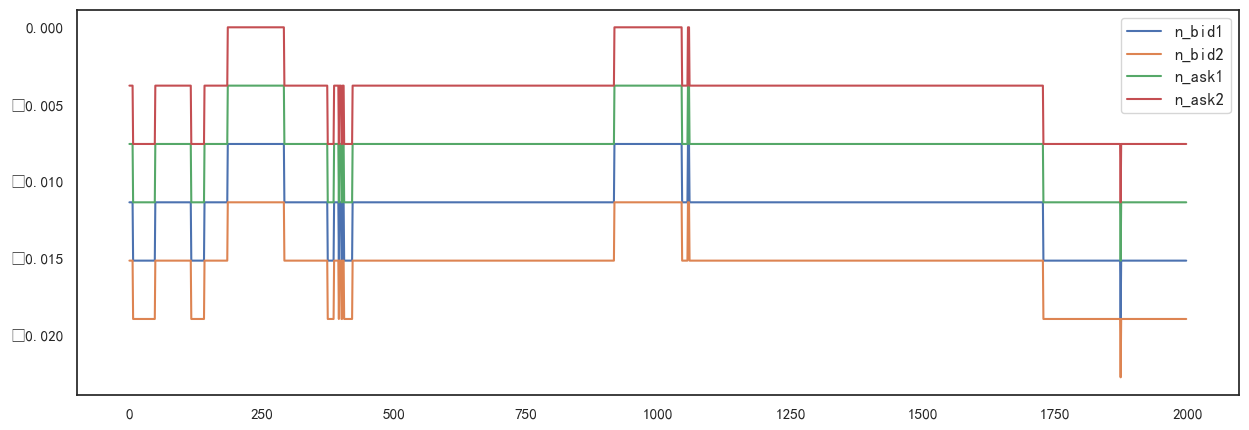

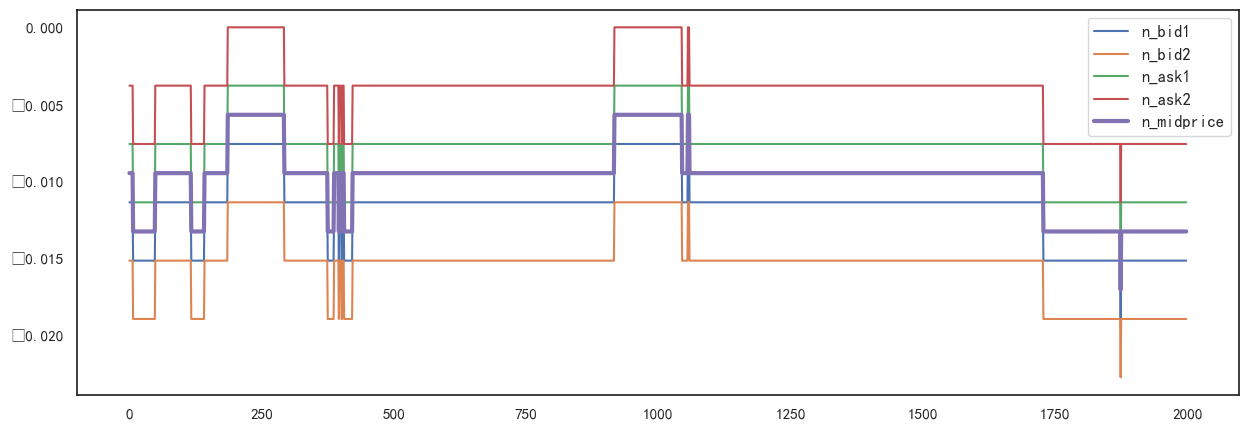

In [78]:
cols = ['n_bid1','n_bid2','n_ask1','n_ask2']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

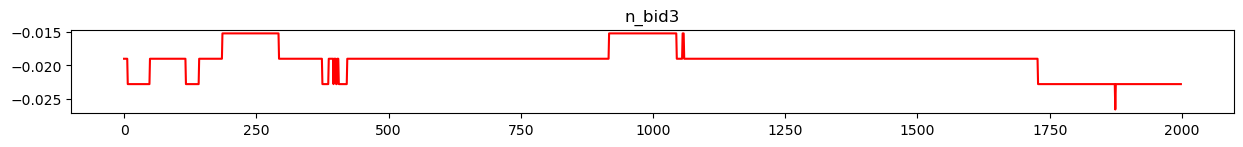

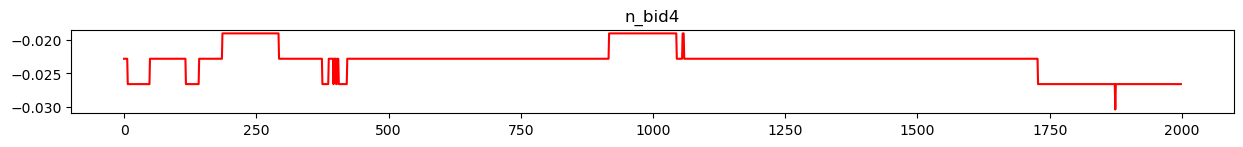

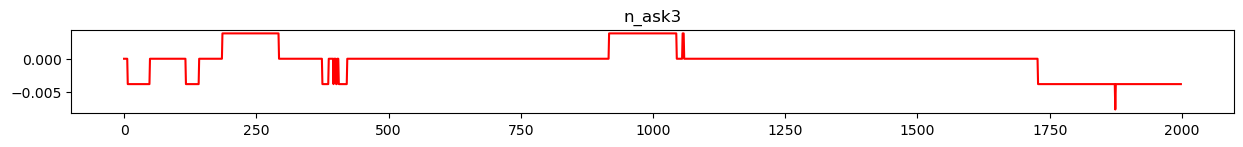

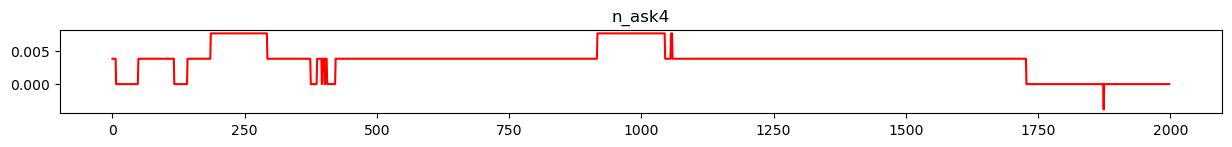

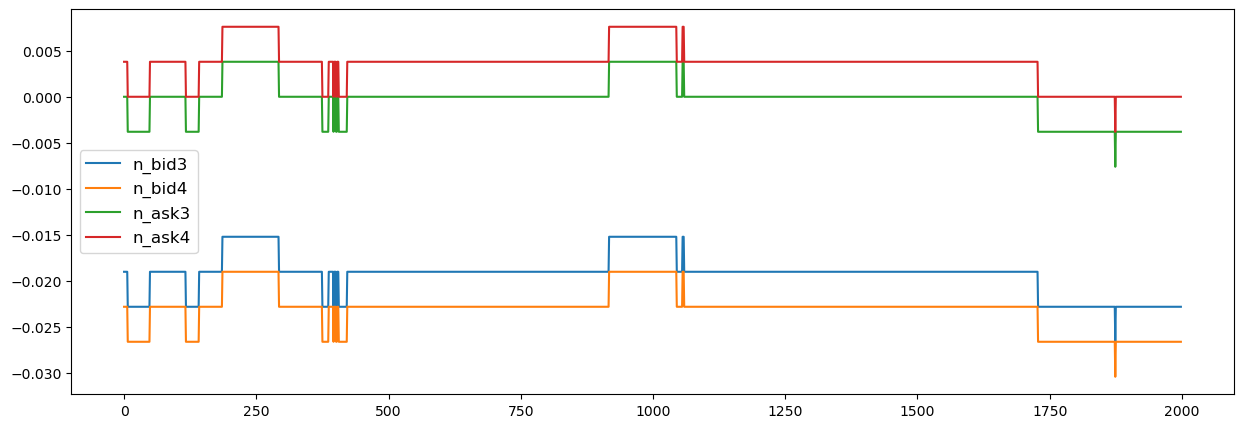

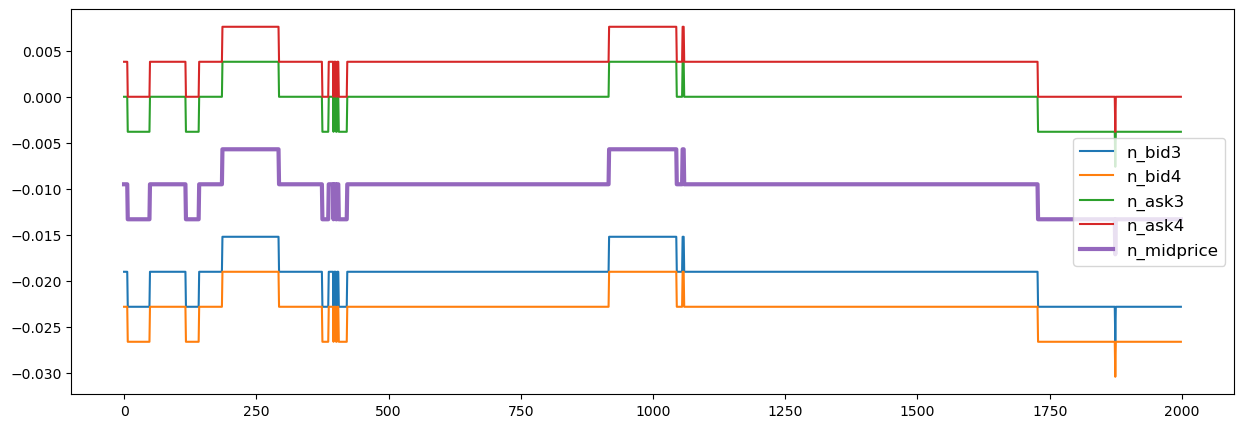

In [8]:
cols = ['n_bid3','n_bid4','n_ask3','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

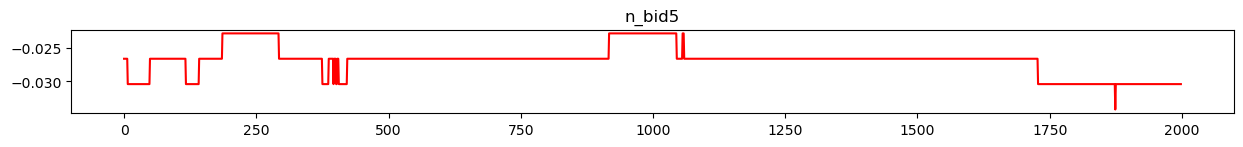

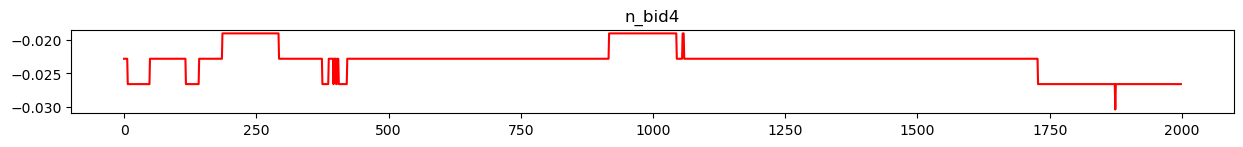

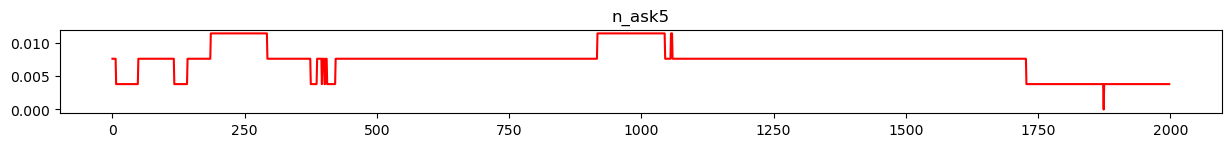

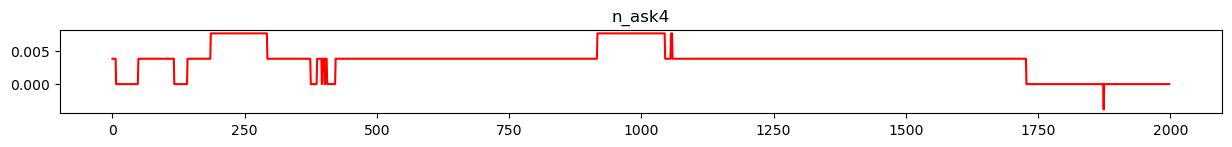

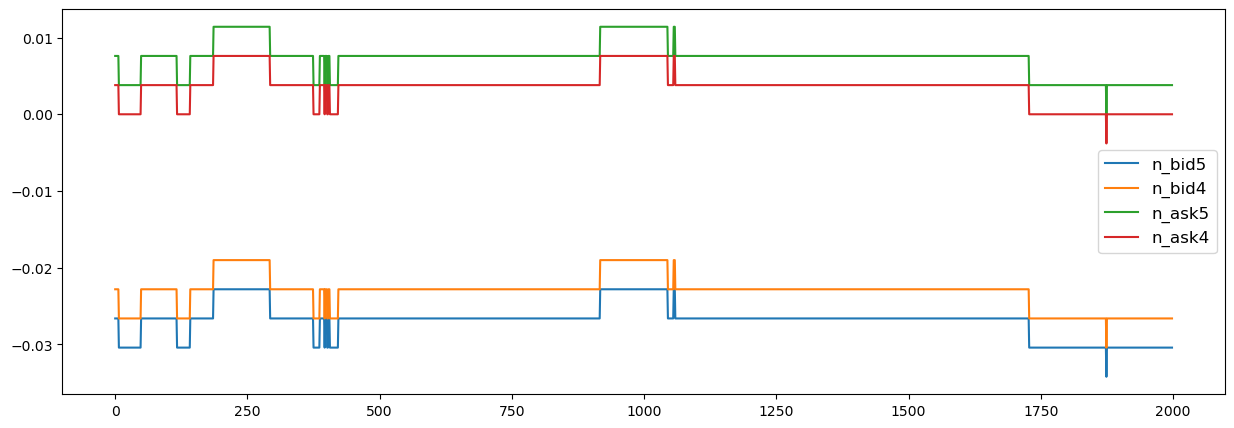

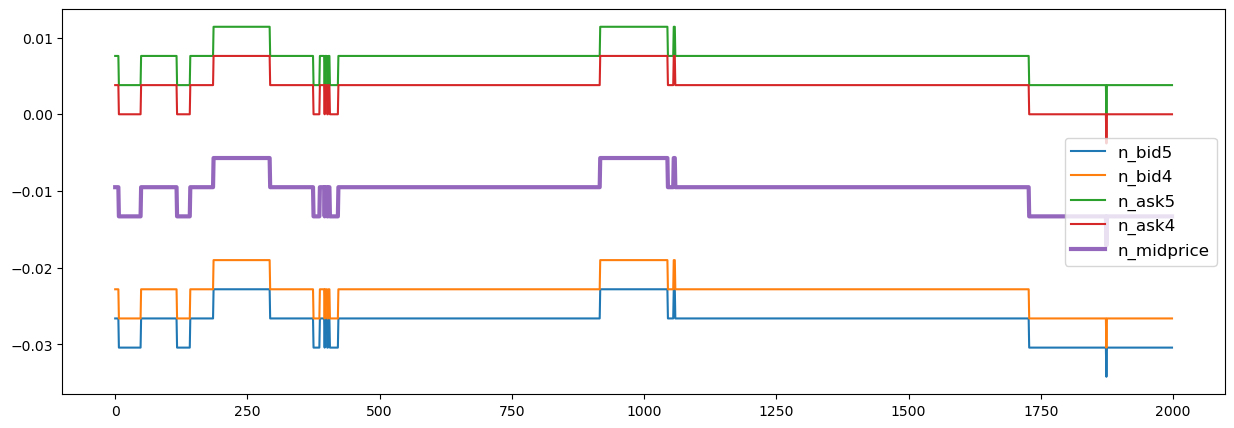

In [9]:
cols = ['n_bid5','n_bid4','n_ask5','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

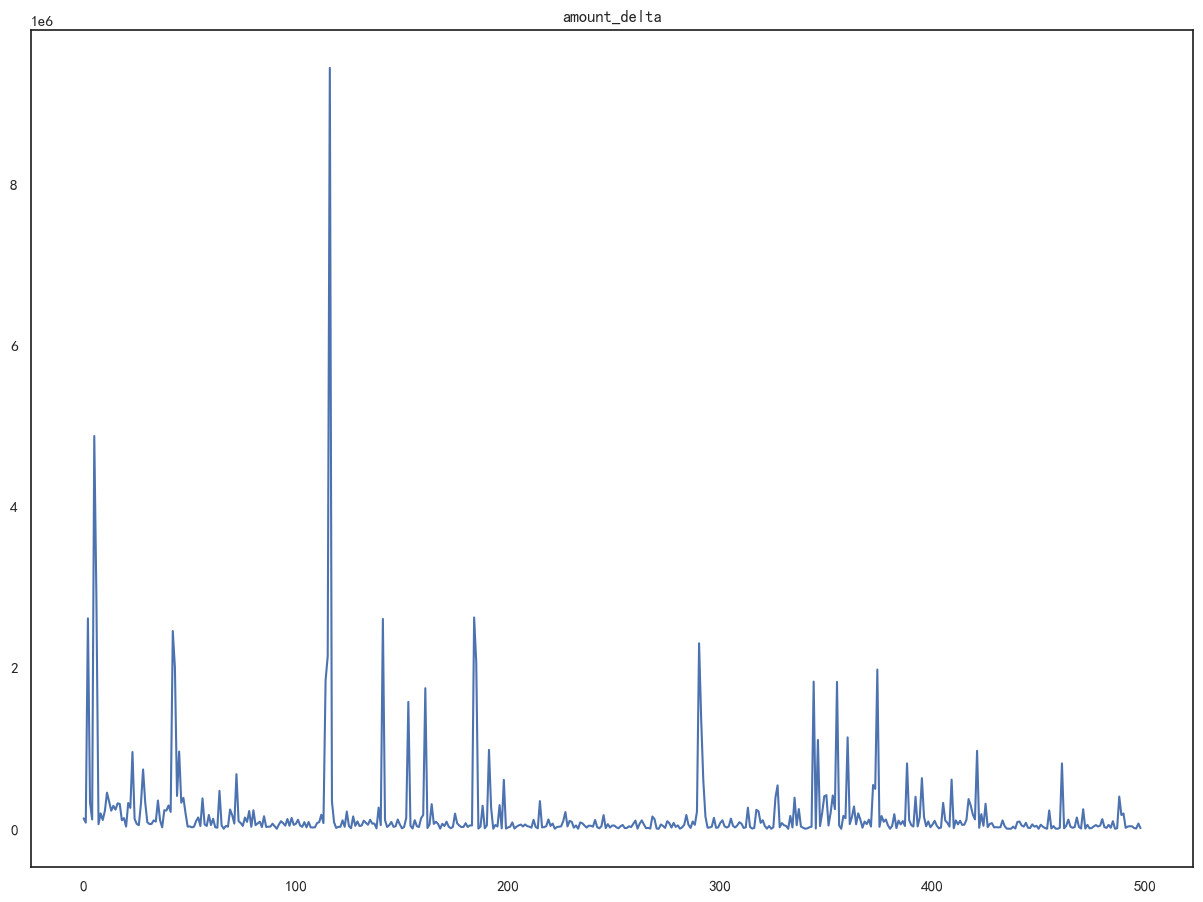

In [79]:
cols = ['amount_delta']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[1:500]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,50))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col])
    plt.title(col)
plt.show()

Text(0, 0.5, 'Price Volatility')

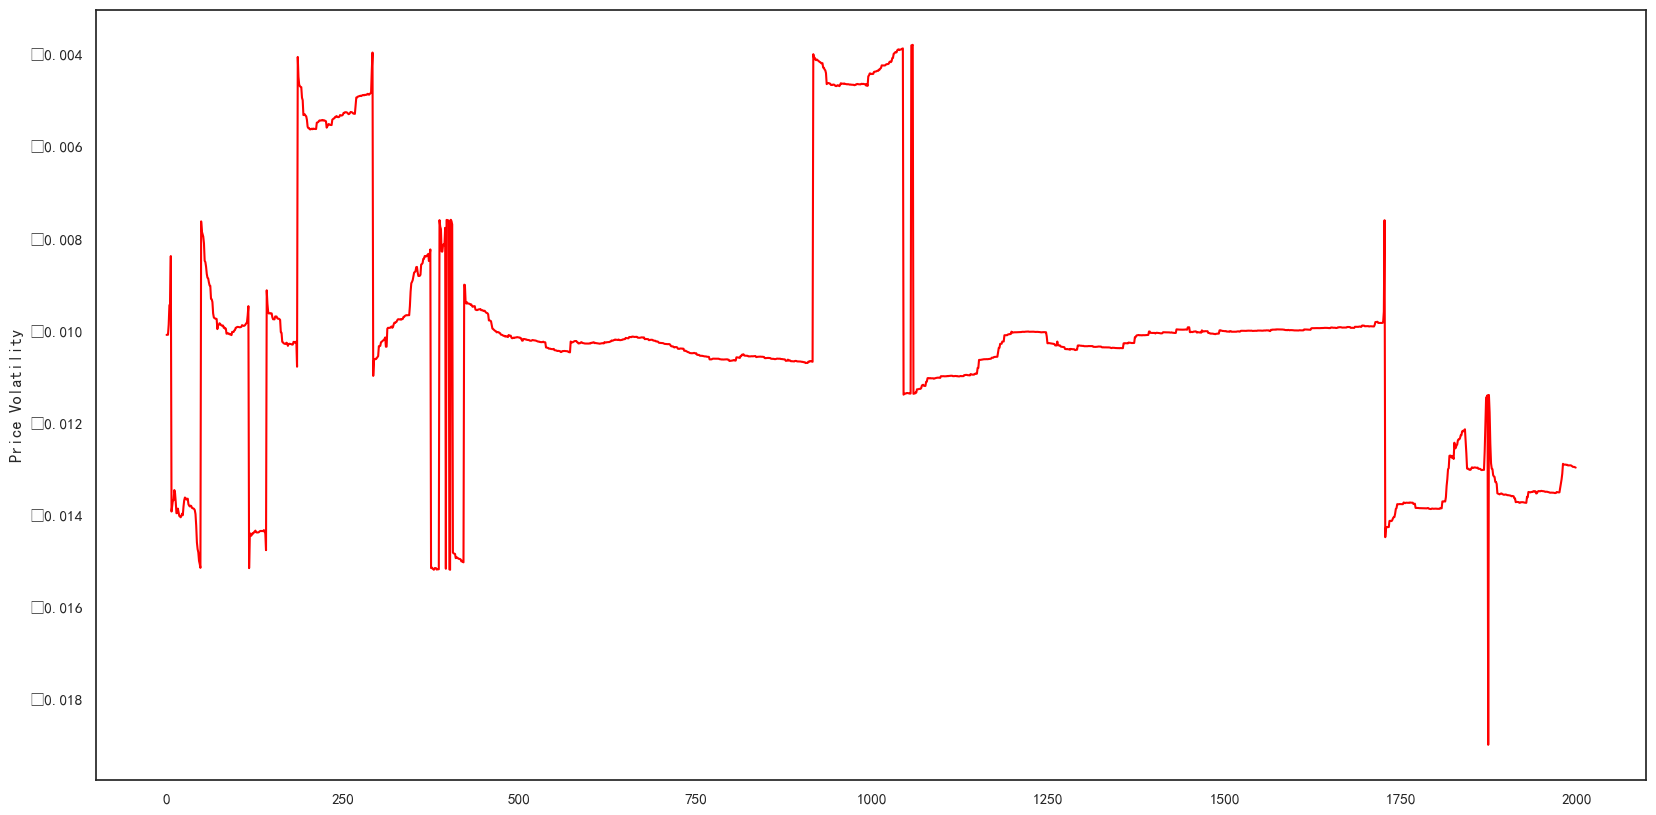

In [80]:
# 波动率是给定股票价格变化的重要统计指标，因此要计算价格变化，我们首先需要在固定间隔进行股票估值。
# 我们将使用已提供的数据的加权平均价格（WAP）进行可视化，WAP的变化反映股票波动情况。
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
plt.figure(figsize=(20,10))
plt.plot(tmp_df['index'], tmp_df['wap1'], color='red')
plt.ylabel('Price Volatility')

In [81]:
# 时间相关特征
train['hour'] = train['time'].apply(lambda x:int(x.split(':')[0]))
test['hour'] = test['time'].apply(lambda x:int(x.split(':')[0]))

train['minute'] = train['time'].apply(lambda x:int(x.split(':')[1]))
test['minute'] = test['time'].apply(lambda x:int(x.split(':')[1]))

# 为了保证时间顺序的一致性，故进行排序
train = train.sort_values(['file','time'])
test = test.sort_values(['file','time'])

# 当前时间特征
# 构建买一卖一和买二卖二相关特征
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

train['wap2'] = (train['n_bid2']*train['n_bsize2'] + train['n_ask2']*train['n_asize2'])/(train['n_bsize2'] + train['n_asize2'])
test['wap2'] = (test['n_bid2']*test['n_bsize2'] + test['n_ask2']*test['n_asize2'])/(test['n_bsize2'] + test['n_asize2'])

train['wap_balance'] = abs(train['wap1'] - train['wap2'])
train['price_spread'] = (train['n_ask1'] - train['n_bid1']) / ((train['n_ask1'] + train['n_bid1'])/2)
train['bid_spread'] = train['n_bid1'] - train['n_bid2']
train['ask_spread'] = train['n_ask1'] - train['n_ask2']
train['total_volume'] = (train['n_asize1'] + train['n_asize2']) + (train['n_bsize1'] + train['n_bsize2'])
train['volume_imbalance'] = abs((train['n_asize1'] + train['n_asize2']) - (train['n_bsize1'] + train['n_bsize2']))

test['wap_balance'] = abs(test['wap1'] - test['wap2'])
test['price_spread'] = (test['n_ask1'] - test['n_bid1']) / ((test['n_ask1'] + test['n_bid1'])/2)
test['bid_spread'] = test['n_bid1'] - test['n_bid2']
test['ask_spread'] = test['n_ask1'] - test['n_ask2']
test['total_volume'] = (test['n_asize1'] + test['n_asize2']) + (test['n_bsize1'] + test['n_bsize2'])
test['volume_imbalance'] = abs((test['n_asize1'] + test['n_asize2']) - (test['n_bsize1'] + test['n_bsize2']))

# 历史平移
# 获取历史信息
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_shift{loc}'] = train.groupby(['file'])[val].shift(loc)
        test[f'file_{val}_shift{loc}'] = test.groupby(['file'])[val].shift(loc)
    
# 差分特征
# 获取与历史数据的增长关系
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_diff{loc}'] = train.groupby(['file'])[val].diff(loc)
        test[f'file_{val}_diff{loc}'] = test.groupby(['file'])[val].diff(loc)
    
# 窗口统计
# 获取历史信息分布变化信息
# 可以尝试更多窗口大小已经统计方式，如min、max、median等
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    train[f'file_{val}_win7_mean'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    train[f'file_{val}_win7_std'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())
    
    test[f'file_{val}_win7_mean'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    test[f'file_{val}_win7_std'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())


In [87]:
def cv_model(clf, train_x, train_y, test_x, test_y, clf_name, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    test_predict = np.zeros([test_x.shape[0], 3])
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('{}* is training'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "xgb":
            # xgboost
            xgb_params = {
              'booster': 'gbtree', 
              'objective': 'multi:softprob',
              'num_class':3,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.1,
              'tree_method': 'hist',
              'seed': 2023,
              'nthread': 16,
              }
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(xgb_params, train_matrix, num_boost_round=300, evals=watchlist)
            val_pred  = model.predict(valid_matrix)
            test_pred = model.predict(test_matrix)
            
        if clf_name == "c45":
            # c45决策树
            model = clf(criterion='entropy',splitter='best',max_depth=6)
            model.fit(trn_x, trn_y)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        
        if clf_name == "cart":
            # cart决策树
            model = clf(criterion='gini',splitter='best',max_depth=6)
            model.fit(trn_x, trn_y)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)

        if clf_name == "rf":
            # 随机森林
            model = clf(n_estimators=50, criterion='gini', max_depth=5)
            model.fit(trn_x, trn_y)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        test_predict += test_pred / kf.n_splits    

    test_label = np.argmax(test_predict, axis=1)
    F1_score = f1_score(test_y, test_label, average='micro')
    print('F1_score:',F1_score)
    return F1_score

In [ ]:
# 处理train_x和test_x中的NaN值
train = train.fillna(0)
test = test.fillna(0)

# 处理train_x和test_x中的Inf值
train = train.replace([np.inf, -np.inf], 0)
test = test.replace([np.inf, -np.inf], 0)

# 把作预测的数据集的特征提取出来
cols_x = [f for f in test.columns if f not in 
          ['uuid','time','file','label_5','label_10','label_20','label_40','label_60']]
for label in ['label_5','label_10','label_20','label_40','label_60']:
# for label in ['label_5']:
    print(f'==== {label} ====')
    # 选择c4.5模型
    c45_test = cv_model(tree.DecisionTreeClassifier,
                        train[cols_x], train[label], test[cols_x], test[label], 'c45')
    # 选择cart模型
    cart_test = cv_model(tree.DecisionTreeClassifier,
                         train[cols_x], train[label], test[cols_x], test[label], 'cart')
    
    # 选择随机森林算法
    cart_test = cv_model(RandomForestClassifier,
                         train[cols_x], train[label], test[cols_x], test[label], 'rf')
    
    # 选择xgboost模型
    xgb_test = cv_model(xgb, train[cols_x], train[label], test[cols_x], test[label], 'xgb')

In [84]:
train

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,file_price_spread_win7_mean,file_price_spread_win7_std,file_bid_spread_win7_mean,file_bid_spread_win7_std,file_ask_spread_win7_mean,file_ask_spread_win7_std,file_total_volume_win7_mean,file_total_volume_win7_std,file_volume_imbalance_win7_mean,file_volume_imbalance_win7_std
0,0,0,09:40:03,1,-0.007605,2081.0,-0.009506,-0.011407,0.000222,-0.015209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,09:40:06,1,-0.011407,129268.0,-0.009506,-0.011407,0.000221,-0.015209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,09:40:09,1,-0.007605,76098.0,-0.009506,-0.011407,0.000221,-0.015209,...,-0.4,0.0,0.003802,0.0,-0.003802,0.0,0.000655,7.553799e-07,0.000049,0.000001
3,3,0,09:40:12,1,-0.007605,2613280.0,-0.009506,-0.011407,0.000174,-0.015209,...,-0.4,0.0,0.003802,0.0,-0.003802,0.0,0.000643,2.312287e-05,0.000037,0.000024
4,4,0,09:40:15,1,-0.011407,327615.0,-0.009506,-0.011407,0.000112,-0.015209,...,-0.4,0.0,0.003802,0.0,-0.003802,0.0,0.000624,4.755572e-05,0.000043,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239875,1994,9,14:49:45,1,0.000000,618749.0,0.001845,0.000000,0.000202,-0.003690,...,2.0,0.0,0.003690,0.0,-0.003690,0.0,0.002185,1.011790e-05,0.000728,0.000009
239876,1995,9,14:49:48,1,0.000000,129328.0,0.001845,0.000000,0.000201,-0.003690,...,2.0,0.0,0.003690,0.0,-0.003690,0.0,0.002182,7.741036e-06,0.000731,0.000009
239877,1996,9,14:49:51,1,0.000000,84124.0,0.001845,0.000000,0.000205,-0.003690,...,2.0,0.0,0.003690,0.0,-0.003690,0.0,0.002183,6.999301e-06,0.000734,0.000007
239878,1997,9,14:49:54,1,0.000000,0.0,0.001845,0.000000,0.000205,-0.003690,...,2.0,0.0,0.003690,0.0,-0.003690,0.0,0.002184,5.196173e-06,0.000737,0.000005


In [88]:
# 处理train_x和test_x中的NaN值
train = train.fillna(0)
test = test.fillna(0)

# 处理train_x和test_x中的Inf值
train = train.replace([np.inf, -np.inf], 0)
test = test.replace([np.inf, -np.inf], 0)

# 把作预测的数据集的特征提取出来
cols_x = [f for f in test.columns if f not in 
          ['uuid','time','file','label_5','label_10','label_20','label_40','label_60']]
for label in ['label_5','label_10','label_20','label_40','label_60']:
# for label in ['label_5']:
    print(f'==== {label} ====')
    # 选择随机森林算法
    cart_test = cv_model(RandomForestClassifier,
                         train[cols_x], train[label], test[cols_x], test[label], 'rf')

==== label_5 ====
1* is training
2* is training
3* is training
4* is training
5* is training
F1_score: 0.9395531098882774
==== label_10 ====
1* is training
2* is training
3* is training
4* is training
5* is training
F1_score: 0.8976988494247123
==== label_20 ====
1* is training
2* is training
3* is training
4* is training
5* is training
F1_score: 0.8258295814573954
==== label_40 ====
1* is training
2* is training
3* is training
4* is training
5* is training
F1_score: 0.7158579289644822
==== label_60 ====
1* is training
2* is training
3* is training
4* is training
5* is training
F1_score: 0.6385692846423212


In [89]:
f1 = pd.read_csv('input/f1_score.csv')
f1.iloc[0]

label            label_60
c45              0.631983
cart             0.640153
xgboost          0.645489
random forest    0.638569
Name: 0, dtype: object

In [90]:
f1['label']

0    label_60
1    label_40
2    label_20
3    label_10
4     label_5
Name: label, dtype: object

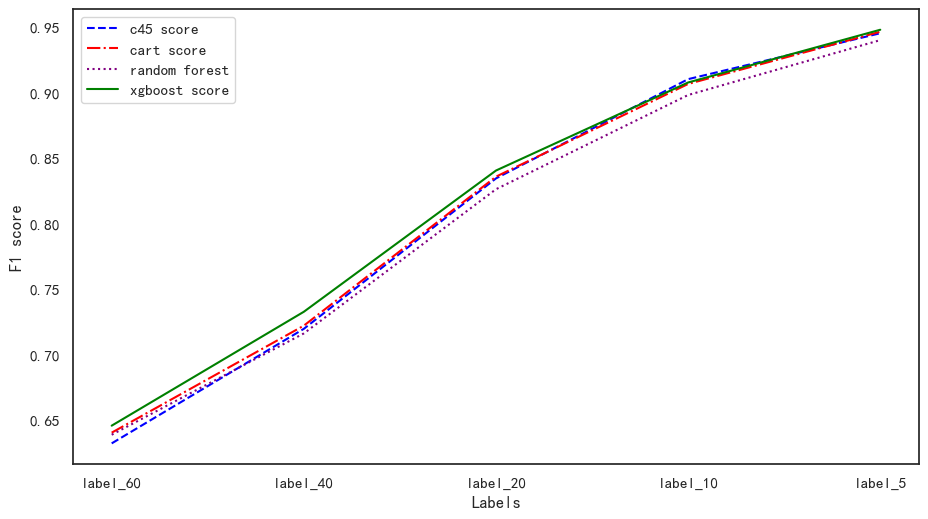

In [91]:
# 绘制得分图
plt.figure(figsize=(24,13))
plt.subplot(221)
plt.plot(f1['label'],f1['c45'],color='blue', ls='--', label='c45 score')
plt.plot(f1['label'],f1['cart'],color='red', ls='-.', label='cart score')
plt.plot(f1['label'],f1['random forest'],color='purple', ls=':', label='random forest')
plt.plot(f1['label'],f1['xgboost'],color='green', label='xgboost score')
plt.xlabel('Labels')
plt.ylabel('F1 score')
plt.legend()